In [1]:
setwd("../../")
pacman::p_load(WGCNA, dplyr, ggplot2)
options(stringsAsFactors = FALSE)

---
## Load input
- Maaslined data for WGCNA, not residued, remove the tech bias but keep the age,gender,..
- The data value is raw

In [2]:
abun=read.csv("data/metagenomics/Specie_abundance_filtered_90percent_maaslined.csv", row.names = 1)
kegg=read.csv("data/metagenomics/KEGG_downsampled_90percent_maaslined.csv", row.names = 1)
immune=read.csv("data/immuno/immune_percentage.csv", row.names = 1)
bioc=read.csv("data/metabolomics/Metabolomics_masslined.csv", row.names = 1)
omics_list = list()
omics_list$bioc = bioc
omics_list$immune = immune
omics_list$abun = abun
omics_list$kegg = kegg

In [3]:
omics_list = list()
omics_list$bioc = bioc
omics_list$immune = immune
omics_list$abun = abun
omics_list$kegg = kegg

In [4]:
lapply(omics_list, dim)

$bioc
[1] 395 414

$immune
[1] 311 489

$abun
[1] 373 479

$kegg
[1] 4462  479

In [5]:
kegg_decode= read.csv("data/metagenomics/KEGG_decode.csv", 
                        header = T, row.names = 1)
kegg_decode = kegg_decode[rownames(omics_list$kegg),]

In [6]:
abun_decode = read.csv("data/metagenomics/metaphlan4_species_full.csv", header = T, row.names = 1)
abun_decode = abun_decode[rownames(omics_list$abun),c(1:7)]

In [7]:
bioc_decode = read.csv("data/metabolomics/QC-norm Data Common wImp_Jan_06_2022.csv", header = T, row.names = 1)
rownames(bioc_decode) = bioc_decode$CHEMICAL_NAME
bioc_decode = bioc_decode[rownames(omics_list$bioc), c("SUPER_PATHWAY","SUB_PATHWAY")]

# Define out folder

In [8]:
outdir = "output/correlation/table/"

---
# Define WGCNA function

In [9]:
Predict_softPower=function(table){
  # Preprocess : remove features with too many missing values
  gsg = goodSamplesGenes(table, tol = 0, minFraction = 0.01, verbose = 4)
  table = table[,gsg$goodGenes]
  table[is.na(table)] = 0
  print(paste("sample #", dim(table)[1], "gene #", dim(table)[2], sep = " "))

  # Choose a set of soft-thresholding powers
  powers = c(c(1:10), seq(from = 12, to=30, by=2))
  # Call the network topology analysis function
  sft = pickSoftThreshold(table, powerVector = powers, verbose = 5)
  
  # Plot the results:
  par(mfrow = c(1,2));
  cex1 = 0.9;
  # Scale-free topology fit index as a function of the soft-thresholding power
  plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
       xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
       main = paste("Scale independence"));
  text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
       labels=powers,cex=cex1,col="red");
  # this line corresponds to using an R^2 cut-off of h
  abline(h=0.90,col="red")
  # Mean connectivity as a function of the soft-thresholding power
  plot(sft$fitIndices[,1], sft$fitIndices[,5],
       xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
       main = paste("Mean connectivity"))
  text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")
  return(table)
}

In [10]:
Clustering_Eigengenes = function(table, title = "", softPower=6, minModuleSize = 10, MEDissThres = 0.25){
  # Clustering
  adjacency = adjacency(table, power = softPower)
  # Turn adjacency into topological overlap
  TOM = TOMsimilarity(adjacency)
  dissTOM = 1-TOM
  geneTree = hclust(as.dist(dissTOM), method = "average")
  # Module identification using dynamic tree cut:
  dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM, deepSplit = 2, pamRespectsDendro = FALSE, 
                              minClusterSize = minModuleSize)
  # Convert numeric lables into colors
  dynamicColors = labels2colors(dynamicMods)
  names(dynamicColors) = colnames(table)
  # Calculate eigengenes
  MEList = moduleEigengenes(table, colors = dynamicColors)
  MEs = MEList$eigengenes
  # Call an automatic merging function
  merge = mergeCloseModules(table, dynamicColors, cutHeight = MEDissThres, verbose = 3)
  mergedColors = merge$colors
  mergedMEs = merge$newMEs
  moduleColors = mergedColors
  # Construct numerical labels corresponding to the colors
  colorOrder = c("grey", standardColors(50))
  # Name labels
  names(mergedColors) = colnames(table)
  MEs = mergedMEs
  table(mergedColors)
  
  # return results: 1) dendrogram 2) eigengenes 3) module membership
  #  1) dendrogram: Plot the dendrogram and colors underneath
  plotDendroAndColors(geneTree, mergedColors, "Dynamic Tree Cut", dendroLabels = FALSE, hang = 0.03,
                      addGuide = TRUE, guideHang = 0.05, 
                      main = paste(title, "Dendrogram and Module Colors", sep = " "))
  # 2) eigengenes
  nGenes = ncol(table)
  nSamples = nrow(table)
  modNames = substring(names(MEs), 3)
  colnames(MEs) = modNames
  
  # 3) module membership 
  # calculate the gene contribution to each module, and p value 
  # by correlate eigengenes with each feature
  geneModuleMembership = as.data.frame(cor(table, MEs, use = "p"))
  MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))
  names(MMPvalue) = paste(names(MMPvalue),".p",sep="")
  MM_table = cbind(mergedColors, geneModuleMembership, MMPvalue)

  # sort the features by their modules and importance
  MM_table_sort = matrix(NA, nrow = 0, ncol = ncol(MM_table)) %>% as.data.frame()
  for (i in unique(MM_table$mergedColors)) {
    MM_table_i = MM_table[MM_table$mergedColors == i, ]
    MM_table_i = MM_table_i[order(MM_table_i[,i], decreasing = T), ]
    MM_table_sort = rbind(MM_table_sort, MM_table_i)
  }
  
  # drop grey
  MEs = MEs[,colnames(MEs) != 'grey']
  MM_table_sort = MM_table_sort[,colnames(MM_table_sort) != 'grey']
  MM_table_sort = MM_table_sort[,colnames(MM_table_sort) != 'grey.p']
  colnames(MEs) = paste(title, colnames(MEs), sep=".")
  colnames(MM_table_sort) = paste(title, colnames(MM_table_sort), sep=".")
  
  return(list(geneTree = geneTree, 
              mergedColors = mergedColors, 
              MEs = MEs, 
              MM_table = MM_table_sort))
}

--- 
# Microbiome Specie Abundance

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 26 genes from the calculation due to too many missing samples or zero variance.
  ..step 2
[1] "sample # 479 gene # 347"
pickSoftThreshold: will use block size 347.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 347 of 347


Warning message:
“executing %dopar% sequentially: no parallel backend registered”


   Power SFT.R.sq slope truncated.R.sq  mean.k. median.k. max.k.
1      1    0.376 -1.53        0.90300 14.50000  1.38e+01 28.600
2      2    0.684 -1.39        0.91600  1.71000  1.50e+00  4.750
3      3    0.280 -3.48        0.17200  0.45800  3.00e-01  2.910
4      4    0.256 -2.71        0.05610  0.20000  8.52e-02  2.510
5      5    0.226 -2.21        0.00493  0.11400  2.65e-02  2.210
6      6    0.256 -2.12        0.06870  0.07610  9.06e-03  1.980
7      7    0.225 -2.38        0.01130  0.05590  3.31e-03  1.800
8      8    0.266 -2.39        0.13100  0.04370  1.23e-03  1.650
9      9    0.270 -2.60        0.10400  0.03550  4.78e-04  1.520
10    10    0.209 -1.84       -0.01590  0.02970  2.04e-04  1.410
11    12    0.214 -1.77       -0.01080  0.02210  3.08e-05  1.230
12    14    0.192 -1.90       -0.01830  0.01720  4.65e-06  1.080
13    16    0.200 -1.87       -0.01050  0.01390  7.53e-07  0.963
14    18    0.171 -1.84        0.06210  0.01140  1.29e-07  0.861
15    20    0.199 -1.94  

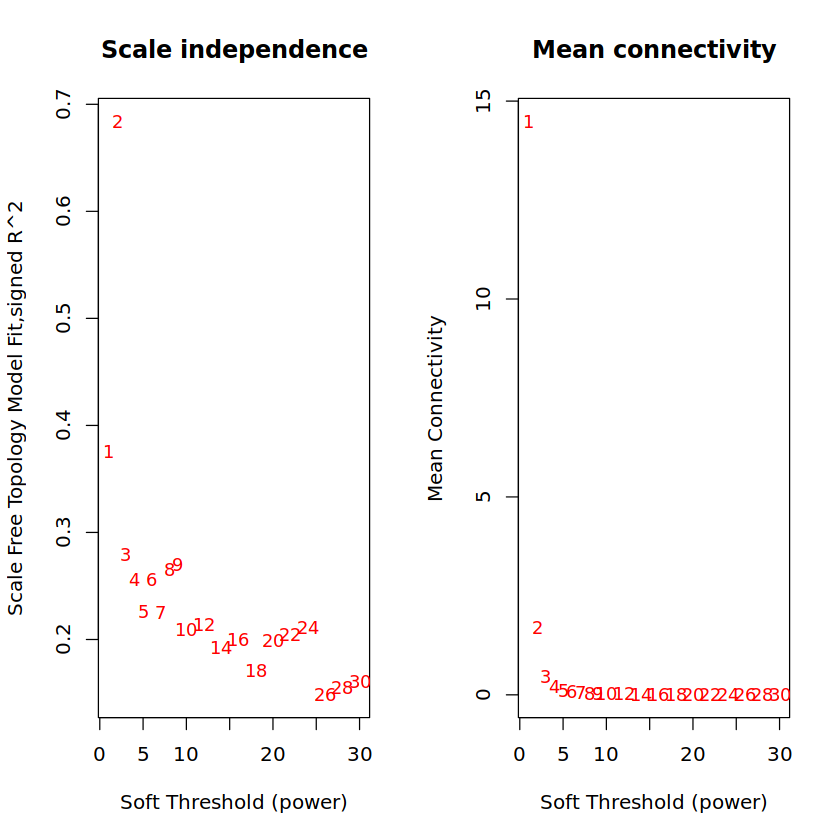

In [11]:
table = t(omics_list$abun)
table[table == 0] = NA
table = Predict_softPower(table)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.994  ===>  99% of the (truncated) height range in dendro.
 ..done.
 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 8 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 8 module eigengenes in given set.


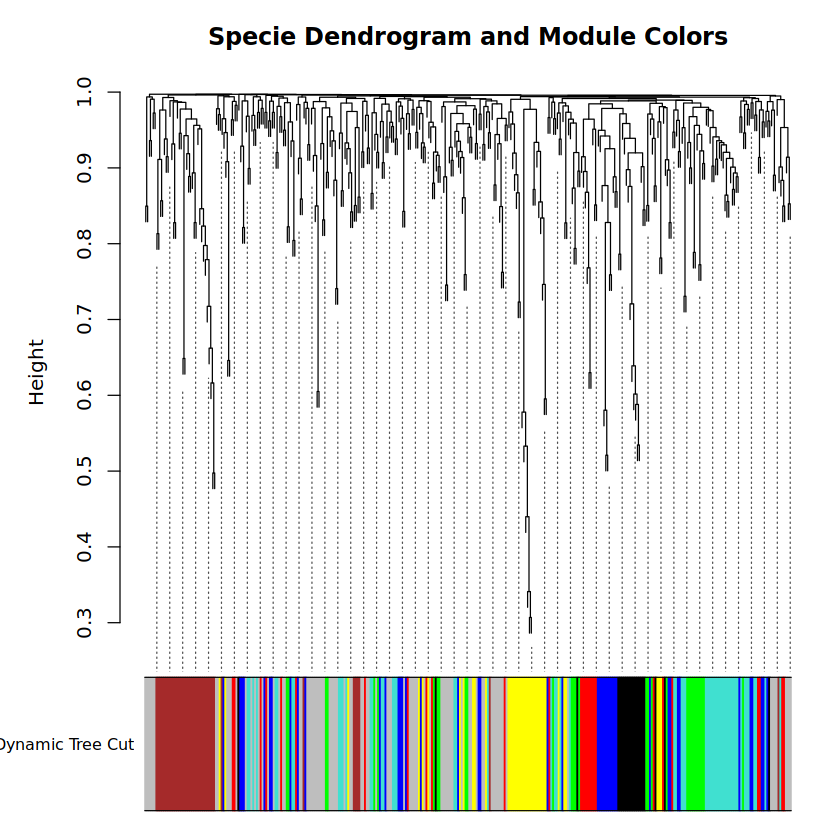

In [12]:
title = "Specie"
softPower = 2
minModuleSize = 9
MEDissThres = 0.25
abun_result = Clustering_Eigengenes(table, title, softPower, minModuleSize, MEDissThres)

In [13]:
#plotDendroAndColors(abun_result$geneTree, abun_result$mergedColors, "Dynamic Tree Cut", dendroLabels = FALSE, hang = 0.03,
#                      addGuide = TRUE, guideHang = 0.05, 
#                      main = paste(title, "Dendrogram and Module Colors", sep = " "))

MEs = abun_result$MEs
write.csv(MEs, paste(outdir, title, "_module_eigengenes.csv", sep = ""))

MM = abun_result$MM_table
MM = cbind(abun_decode[rownames(MM), ], MM)
write.csv(MM, paste(outdir, title, "_feature_importance.csv", sep = ""))

---
# Microbiome KEGG gene

 Flagging genes and samples with too many missing values...
  ..step 1
[1] "sample # 479 gene # 4462"
pickSoftThreshold: will use block size 4462.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4462 of 4462
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.125  0.240        -0.0762  1050.0   999.000   1830
2      2    0.341 -0.554         0.2830   562.0   384.000   1360
3      3    0.395 -0.695         0.6150   401.0   180.000   1200
4      4    0.369 -0.675         0.8160   320.0   101.000   1100
5      5    0.354 -0.636         0.9080   269.0    66.100   1020
6      6    0.368 -0.606         0.9710   234.0    43.700    956
7      7    0.342 -0.567         0.9710   207.0    29.800    902
8      8    0.385 -0.581         0.9600   186.0    20.500    855
9      9    0.425 -0.577         0.9510   168.0    14.900    814
10    10    0.482 -0.582         0.9490   154.0    10.900    777
11    12    0.543 -0.583    

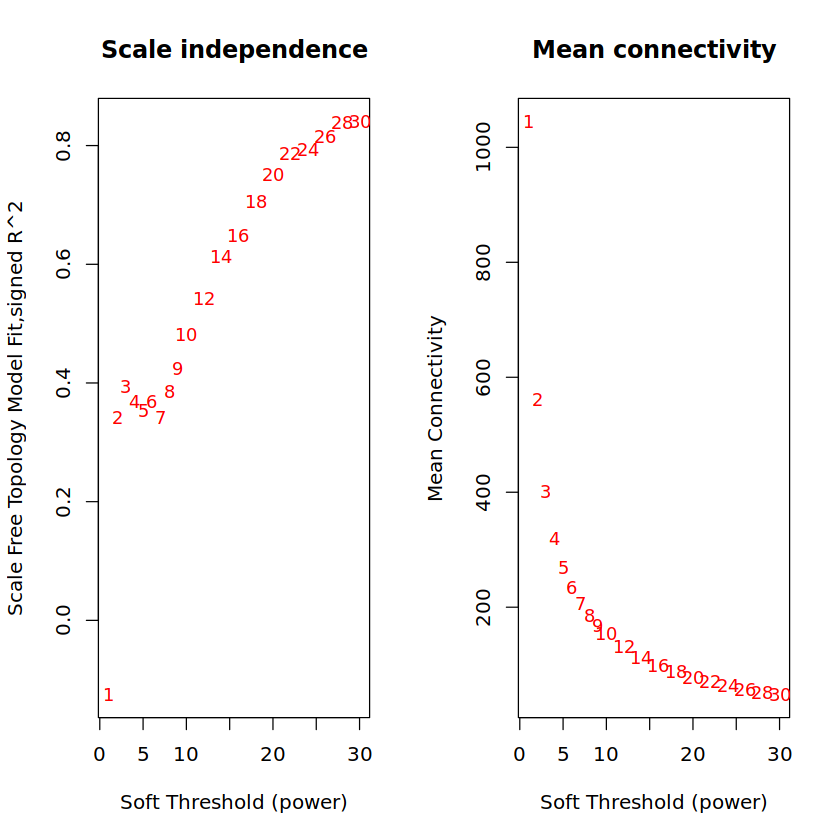

In [14]:
table = t(omics_list$kegg)
table[table == 0] = NA
table = Predict_softPower(table)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.993  ===>  99% of the (truncated) height range in dendro.
 ..done.
 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.


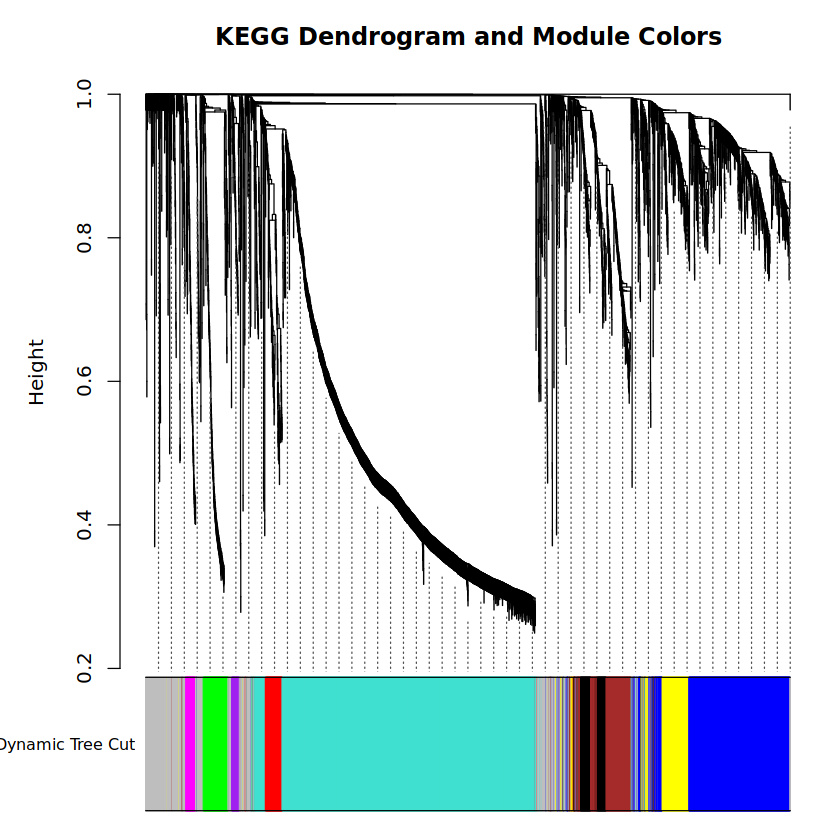

In [15]:
softPower = 8
title = "KEGG"
minModuleSize = 50
MEDissThres = 0.25
kegg_result = Clustering_Eigengenes(table, title, softPower, minModuleSize, MEDissThres)

MEs = kegg_result$MEs
write.csv(MEs, paste(outdir, title, "_module_eigengenes.csv", sep = ""))

In [16]:
MM = kegg_result$MM_table
MM = cbind(kegg_decode[rownames(MM), ], MM)
write.csv(MM, paste(outdir, title, "_feature_importance.csv", sep = ""))

---
# Conclusion: No merge 
# Test Microbiome: combine KEGG gene + abundance

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 26 genes from the calculation due to too many missing samples or zero variance.
  ..step 2
[1] "sample # 479 gene # 4809"
pickSoftThreshold: will use block size 4809.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4809 of 4809
   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0129  0.0572         -0.264  1010.0   969.000   1860
2      2   0.4030 -0.6020          0.354   527.0   345.000   1370
3      3   0.4290 -0.7220          0.626   374.0   160.000   1200
4      4   0.3980 -0.6990          0.815   298.0    87.800   1100
5      5   0.3810 -0.6600          0.906   250.0    55.800   1020
6      6   0.3920 -0.6280          0.970   217.0    35.200    957
7      7   0.3660 -0.5890          0.972   192.0    23.300    903
8      8   0.4070 -0.6010          0.962   173.0    16.300    856
9      9   0.4450 -0.5940          0.955   1

,K00001,K00002,K00003,K00004,K00005,K00008,K00009,K00010,K00012,K00013,⋯,GGB4197_SGB5684,Megasphaera_elsdenii,Veillonella_atypica,Holdemania_sp_Marseille_P2844,GGB9621_SGB15073,GGB9635_SGB15102,Bacilli_unclassified_SGB6428,GGB4250_SGB5751,Blautia_SGB4831,Prevotella_SGB1680
SAM000201_tp1,232.74307,11.9355421,276.50673,0.0000000,46.74754,137.25873,11.935542,54.70457,1042.3707,495.3250,⋯,0.0000000,0,0.00e+00,0.0000000,0.0000000,0,0,0,0.0000000,0
SAM000201_tp2,135.81820,14.4231714,405.05073,2.4038619,104.56799,191.10702,9.615448,32.45214,1191.1136,561.3018,⋯,0.0175757,0,0.00e+00,0.0002674,0.0000000,0,0,0,0.0000000,0
SAM000201_tp3,117.63793,6.8394147,287.25542,1.3678829,83.44086,186.03208,42.404371,51.97955,1425.3340,477.3911,⋯,0.0000000,0,0.00e+00,0.0000000,0.0000000,0,0,0,0.0000000,0
SAM000201_tp4,179.74844,22.9753649,367.60584,1.3514921,137.85219,310.84317,64.871619,79.73803,958.2079,612.2259,⋯,0.0000000,0,0.00e+00,0.0000000,0.0000000,0,0,0,0.0001955,0
SAM000202_tp1,155.85778,7.2251953,367.45279,0.0000000,140.37522,201.27330,1.032171,41.28683,1118.8731,555.3079,⋯,0.0000000,0,0.00e+00,0.0000000,0.0000000,0,0,0,0.0001833,0
SAM000202_tp2,159.87113,4.0731499,341.12630,0.0000000,140.52367,181.25517,10.182875,38.69492,1252.4936,631.3382,⋯,0.0000000,0,0.00e+00,0.0000000,0.0000000,0,0,0,0.0003471,0
SAM000202_tp3,115.32204,26.4673530,470.74078,0.0000000,62.38733,203.23146,95.471523,84.12837,887.6016,656.0122,⋯,0.0000000,0,0.00e+00,0.0000000,0.0000000,0,0,0,0.0000000,0
SAM000202_tp4,104.44737,1.0239939,400.38160,0.0000000,53.24768,59.39164,162.815023,78.84753,1064.9536,518.1409,⋯,0.0000000,0,0.00e+00,0.0000000,0.0000000,0,0,0,0.0000000,0
SAM000203_tp1,306.74898,5.4132173,71.27403,0.0000000,37.89252,230.06174,8.119826,10.82643,1059.1862,529.5931,⋯,0.0000000,0,0.00e+00,0.0000000,0.0000000,0,0,0,0.0000000,0
SAM000203_tp2,197.30019,4.3267586,83.07377,0.8653517,40.67153,239.70243,3.461407,19.90309,1065.2480,606.6116,⋯,0.0000000,0,0.00e+00,0.0000000,0.0000000,0,0,0,0.0000000,0


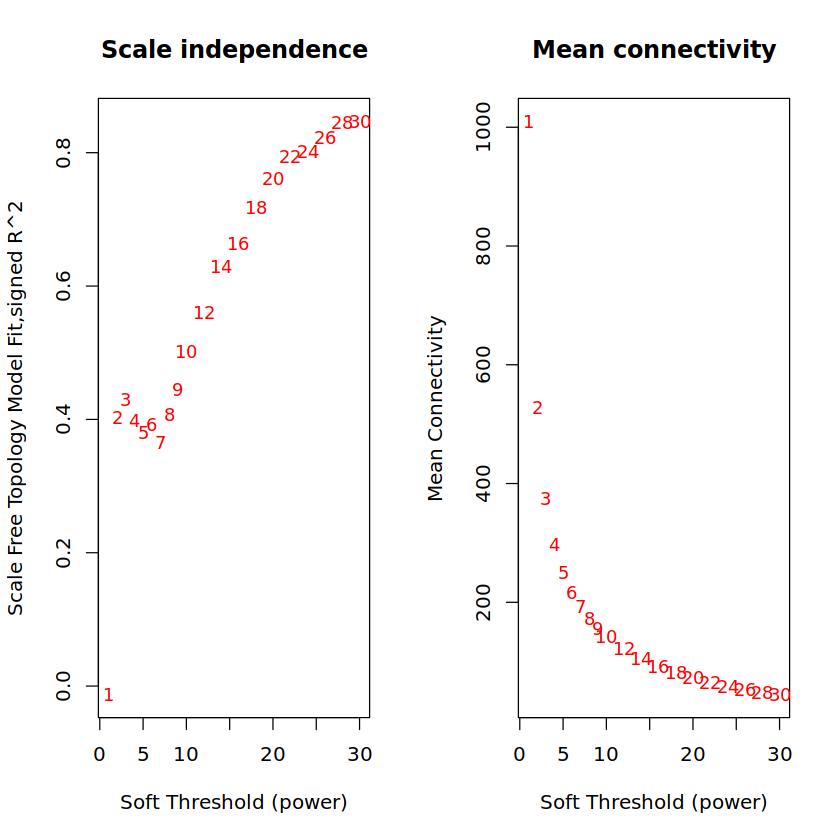

In [17]:
table = t(rbind(kegg, abun))
table[table == 0] = NA
Predict_softPower(table)

Warning message in (function (x, y = NULL, use = "all.obs", method = c("pearson", :
“Missing values generated in calculation of cor. Likely cause: too many missing entries or zero variance.”


..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.991  ===>  99% of the (truncated) height range in dendro.
 ..done.


Warning message in knnimp(x, k, maxmiss = rowmax, maxp = maxp):
“20 rows with more than 50 % entries missing;
 mean imputation used for these rows”
Warning message in knnimp(x, k, maxmiss = rowmax, maxp = maxp):
“77 rows with more than 50 % entries missing;
 mean imputation used for these rows”


Cluster size 2620 broken into 2538 82 
Cluster size 2538 broken into 2039 499 
Cluster size 2039 broken into 573 1466 
Done cluster 573 
Done cluster 1466 
Done cluster 2039 
Done cluster 499 
Done cluster 2538 
Done cluster 82 
 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 18 module eigengenes in given set.
      ..principal component calculation for module black failed with the following error:
           Error in impute.knn(datModule, k = min(10, nrow(datModule) - 1)) : 
  a column has more than 80 % missing values!
       ..hub genes will be used instead of principal components.
      ..principal component calculation for module blue failed with the following error:
           Error in impute.knn(datModule, k = min(10, nrow(datModule) - 1)) : 
  a column has more than 80 % missing values!
       ..hub genes will be used instead of principal components.
      .

Warning message in knnimp(x, k, maxmiss = rowmax, maxp = maxp):
“20 rows with more than 50 % entries missing;
 mean imputation used for these rows”


      ..principal component calculation for module purple failed with the following error:
           Error in impute.knn(datModule, k = min(10, nrow(datModule) - 1)) : 
  a column has more than 80 % missing values!
       ..hub genes will be used instead of principal components.
      ..principal component calculation for module red failed with the following error:
           Error in impute.knn(datModule, k = min(10, nrow(datModule) - 1)) : 
  a column has more than 80 % missing values!
       ..hub genes will be used instead of principal components.
      ..principal component calculation for module salmon failed with the following error:
           Error in impute.knn(datModule, k = min(10, nrow(datModule) - 1)) : 
  a column has more than 80 % missing values!
       ..hub genes will be used instead of principal components.
      ..principal component calculation for module tan failed with the following error:
           Error in impute.knn(datModule, k = min(10, nrow(datModule) - 

Warning message in knnimp(x, k, maxmiss = rowmax, maxp = maxp):
“77 rows with more than 50 % entries missing;
 mean imputation used for these rows”


Cluster size 2620 broken into 2538 82 
Cluster size 2538 broken into 2039 499 
Cluster size 2039 broken into 573 1466 
Done cluster 573 
Done cluster 1466 
Done cluster 2039 
Done cluster 499 
Done cluster 2538 
Done cluster 82 
      ..principal component calculation for module yellow failed with the following error:
           Error in impute.knn(datModule, k = min(10, nrow(datModule) - 1)) : 
  a column has more than 80 % missing values!
       ..hub genes will be used instead of principal components.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 12 module eigengenes in given set.
      ..principal component calculation for module black failed with the following error:
           Error in impute.knn(datModule, k = min(10, nrow(datModule) - 1)) : 
  a column has more than 80 % missing values!
       ..hub genes will be used instead of principal components.
      ..principal component calculation for module blue failed with the fo

Warning message in knnimp(x, k, maxmiss = rowmax, maxp = maxp):
“97 rows with more than 50 % entries missing;
 mean imputation used for these rows”


Cluster size 2705 broken into 328 2377 
Done cluster 328 
Cluster size 2377 broken into 564 1813 
Done cluster 564 
Cluster size 1813 broken into 1315 498 
Done cluster 1315 
Done cluster 498 
Done cluster 1813 
Done cluster 2377 
      ..principal component calculation for module purple failed with the following error:
           Error in impute.knn(datModule, k = min(10, nrow(datModule) - 1)) : 
  a column has more than 80 % missing values!
       ..hub genes will be used instead of principal components.
      ..principal component calculation for module salmon failed with the following error:
           Error in impute.knn(datModule, k = min(10, nrow(datModule) - 1)) : 
  a column has more than 80 % missing values!
       ..hub genes will be used instead of principal components.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.
      ..principal component calculation for module black failed with th

Warning message in knnimp(x, k, maxmiss = rowmax, maxp = maxp):
“97 rows with more than 50 % entries missing;
 mean imputation used for these rows”


Cluster size 2705 broken into 328 2377 
Done cluster 328 
Cluster size 2377 broken into 564 1813 
Done cluster 564 
Cluster size 1813 broken into 1315 498 
Done cluster 1315 
Done cluster 498 
Done cluster 1813 
Done cluster 2377 
      ..principal component calculation for module salmon failed with the following error:
           Error in impute.knn(datModule, k = min(10, nrow(datModule) - 1)) : 
  a column has more than 80 % missing values!
       ..hub genes will be used instead of principal components.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.
      ..principal component calculation for module black failed with the following error:
           Error in impute.knn(datModule, k = min(10, nrow(datModule) - 1)) : 
  a column has more than 80 % missing values!
       ..hub genes will be used instead of principal components.
      ..principal component calculation for mo

Warning message in knnimp(x, k, maxmiss = rowmax, maxp = maxp):
“97 rows with more than 50 % entries missing;
 mean imputation used for these rows”


Cluster size 2705 broken into 328 2377 
Done cluster 328 
Cluster size 2377 broken into 564 1813 
Done cluster 564 
Cluster size 1813 broken into 1315 498 
Done cluster 1315 
Done cluster 498 
Done cluster 1813 
Done cluster 2377 
      ..principal component calculation for module salmon failed with the following error:
           Error in impute.knn(datModule, k = min(10, nrow(datModule) - 1)) : 
  a column has more than 80 % missing values!
       ..hub genes will be used instead of principal components.


Warning message in cor(table, MEs, use = "p"):
“Missing values generated in calculation of cor. Likely cause: too many missing entries or zero variance.”


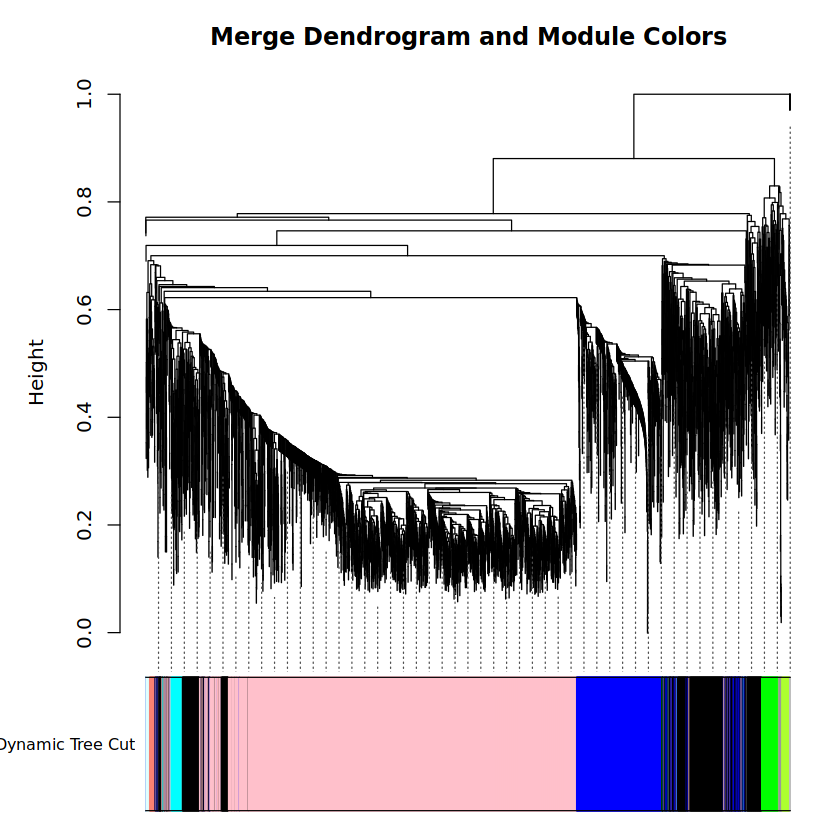

In [18]:
softPower = 20
title = "Merge"
minModuleSize = 20
MEDissThres = 0.25
result = Clustering_Eigengenes(table, title, softPower, minModuleSize, MEDissThres)

---
## Immune

 Flagging genes and samples with too many missing values...
  ..step 1
[1] "sample # 489 gene # 311"
pickSoftThreshold: will use block size 311.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 311 of 311
   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.00127  0.0558          0.856  41.400   39.5000  71.70
2      2  0.60400 -0.9410          0.748  11.800   10.1000  30.60
3      3  0.82200 -0.9070          0.795   5.470    3.9300  17.60
4      4  0.97000 -0.8720          0.967   3.380    2.1900  12.30
5      5  0.91500 -0.9170          0.901   2.430    1.4500   9.76
6      6  0.89000 -0.9340          0.886   1.890    1.0400   8.18
7      7  0.91600 -0.9280          0.922   1.550    0.8280   7.09
8      8  0.92900 -0.9410          0.946   1.310    0.6580   6.31
9      9  0.91800 -0.9470          0.947   1.140    0.5410   5.73
10    10  0.88700 -0.9660          0.945   1.010    0.4780   5.28
11    12  0.87100 -1.

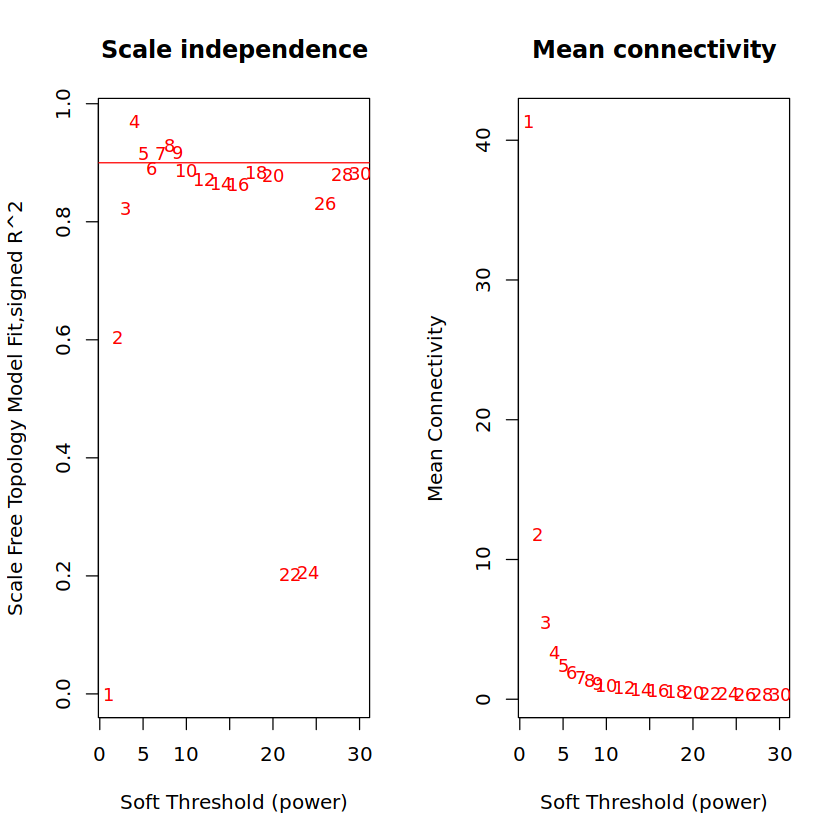

In [19]:
table = t(omics_list$immune)
table[table == 0] = NA
table = Predict_softPower(table)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.994  ===>  99% of the (truncated) height range in dendro.
 ..done.
 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 12 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.


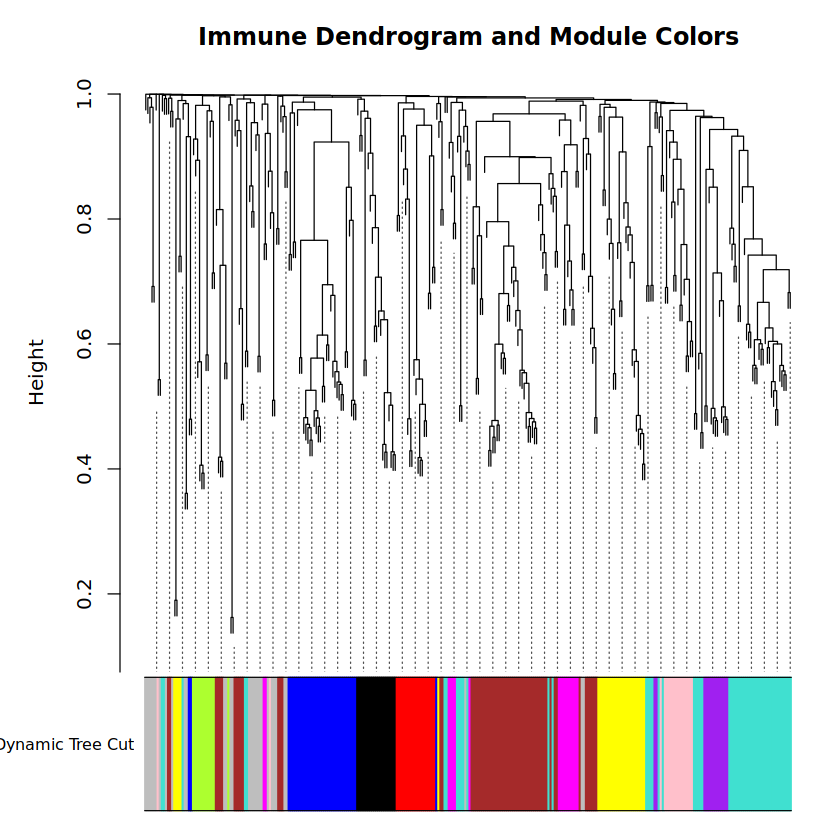

In [20]:
softPower = 4
title = "Immune"
minModuleSize = 10
MEDissThres = 0.25
immune_result = Clustering_Eigengenes(table, title, softPower, minModuleSize, MEDissThres)

MEs = immune_result$MEs
write.csv(MEs, paste(outdir, title, "_module_eigengenes.csv", sep = ""))

MM = immune_result$MM_table
write.csv(MM, paste(outdir, title, "_feature_importance.csv", sep = ""))

---
# Metabolomics

 Flagging genes and samples with too many missing values...
  ..step 1
[1] "sample # 414 gene # 395"
pickSoftThreshold: will use block size 395.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 395 of 395
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.173 -1.270         0.9340 39.3000  3.86e+01 74.100
2      2    0.470 -0.977         0.9800  8.2400  7.37e+00 22.700
3      3    0.871 -0.997         0.9630  2.8900  2.19e+00  9.950
4      4    0.905 -1.210         0.9600  1.4400  9.34e-01  6.770
5      5    0.912 -1.430         0.9780  0.8760  4.75e-01  5.750
6      6    0.910 -1.520         0.9290  0.6020  2.73e-01  5.020
7      7    0.926 -1.560         0.9620  0.4460  1.71e-01  4.450
8      8    0.933 -1.550         0.9540  0.3460  1.15e-01  3.990
9      9    0.938 -1.500         0.9500  0.2770  7.27e-02  3.610
10    10    0.901 -1.510         0.8910  0.2280  5.02e-02  3.290
11    12    0.259 -2.270        

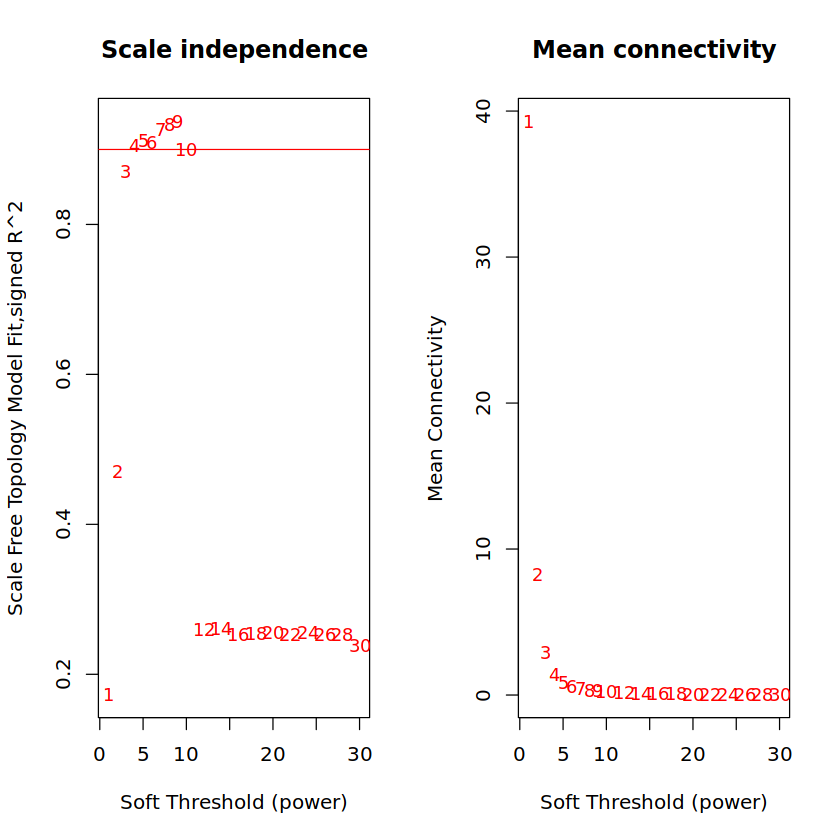

In [21]:
table = t(omics_list$bioc)
table[table == 0] = NA
table = Predict_softPower(table)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.995  ===>  99% of the (truncated) height range in dendro.
 ..done.
 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.


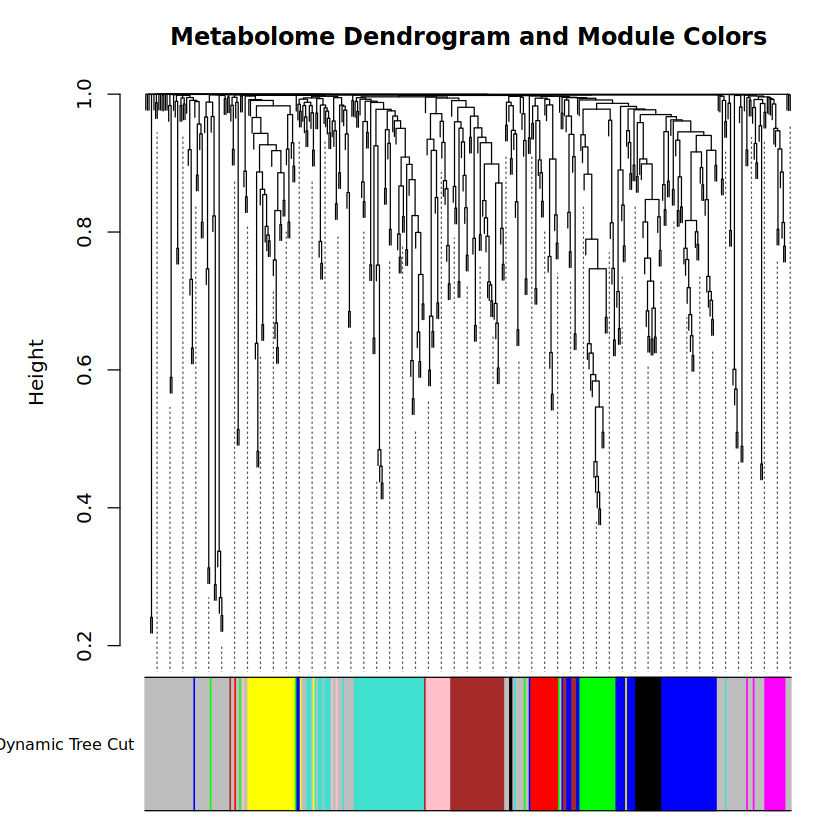

In [22]:
softPower = 4
minModuleSize = 10
title = "Metabolome"
MEDissThres = 0.25
bioc_result = Clustering_Eigengenes(table, title, softPower, minModuleSize, MEDissThres)

MEs = bioc_result$MEs
write.csv(MEs, paste(outdir, title, "_module_eigengenes.csv", sep = ""))

MM = bioc_result$MM_table
MM = cbind(bioc_decode[rownames(MM), ], MM)
write.csv(MM, paste(outdir, title, "_feature_importance.csv", sep = ""))

---
# Save results

In [23]:
saveRDS(list(abun_result = abun_result, 
             kegg_result = kegg_result, 
             immune_result = immune_result, 
             bioc_result = bioc_result), 
        file = paste(outdir, "WGCNA_geneTrees.rds", sep = ""))